<a href="https://colab.research.google.com/github/CarlosEduardoBH/santander/blob/main/Santander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Santander Customer Satisfaction

---


## Descrição do Problema

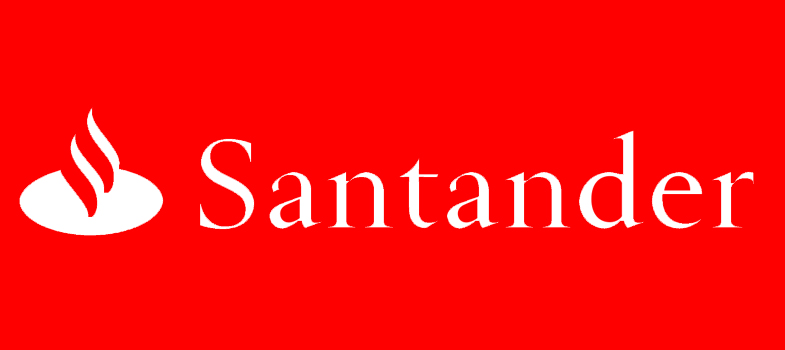

A satisfação do cliente é chave do sucesso. Os clientes insatisfeitos não ficam por perto. Além do mais, clientes insatisfeitos raramente expressam sua insatisfação antes de sair.

O Banco Santander está pedindo para ajudar a identificar os clientes insatisfeitos no início de seu relacionamento. Isso permitiria ao Santander tomar medidas proativas para melhorar a felicidade do cliente antes que seja tarde demais.


Neste projeto, criado pelo [Kaggle](https://www.kaggle.com/c/santander-customer-satisfaction), iremos trabalhará com centenas de recursos anônimos para prever se um cliente está satisfeito ou insatisfeito com sua experiência bancária.


Iremos Utilizar o **Python** para Criar modelo de Machine Learning e utilizar técnicas avançadas para prever e o cliente está ou não satisfeito.

# Carregando os Dados

## Importando as Bibliotecas
Vamos importar todas bibliotecas necessárias para exploração e transformação dos dados 

In [1]:
# Imports para manipulação de dados.
import pandas as pd
import numpy as np
# Imports para visualização de dados
import seaborn as sns
# Formatando as saídas dos gráficos
sns.set()
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-deep')
%matplotlib inline
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.io as pio
pio.renderers
pio.renderers.default = 'colab'


# Para ocultar Future Warnings.
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# import para balancementos das clases
from imblearn.over_sampling import SMOTE

# imports para a etapa de pré-processamento dos dados
from sklearn.preprocessing import MinMaxScaler, normalize, LabelEncoder, StandardScaler, PowerTransformer

# imports para a fase de Feature Selection.
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif, f_classif, RFE, chi2, VarianceThreshold

# import para gerar os modelo/algoritimos

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

#import para calcular as métricas de avaliação dos modelos.
from sklearn.metrics import accuracy_score, balanced_accuracy_score, average_precision_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, cohen_kappa_score

import timeit
import time

Carregando os Dados de Treino e Test

In [ ]:
# Carregando os dados de treino
dataTrain = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Santander/train.csv')
# visualizando os 5 primeiros registros
dataTrain.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [ ]:
# Carregando os dados de teste
dataTest = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Santander/test.csv')
# visualizando os 5 primeiros registros
dataTest.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.43,6.00,4.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2.55,3.00,2.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,60.0,60.0,60.0,60.0,60.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,57.00,51.45,66.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.87,30.00,21.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


### Analisando os dados de treino e teste

In [ ]:
# verificando o shape dos dados
print("Temos " + str(dataTrain.shape[1]) + " Colunas e " + str(dataTrain.shape[0]) + " linhas em nosso dados.")

Temos 371 Colunas e 76020 linhas em nosso dados.


A coluna "**TARGET**" é a variável a ser prevista. É igual a **1** para clientes **insatisfeitos** e **0** para clientes **satisfeitos**.

Os dados de teste tem uma coluna a menos (não tem a "TARGET"), será usada para avaliarmos o modelo.

Vamos eliminar a coluna ID de nosso dados de treino, pois não tem correlação com os dados e não agrega valor para modelo.


In [ ]:
# Eliminando a coluna ID dados de Treino.
df = dataTrain.drop('ID', axis=1)

In [ ]:
# verificando registros duplicados
print("Duplicidade nos dados de Treino: ", df.duplicated().sum())

Duplicidade nos dados de Treino:  4807


Observamos **4.807** registros **duplicados** em nossos dados de Treino. Vamos deletar a duplicidade


In [ ]:
# deletando os registros duplicados nos dados de treino
df = df.drop_duplicates()

In [ ]:
# verificando o tipo de dados
df.dtypes.value_counts()

int64      259
float64    111
dtype: int64

Todas as variaveis de nosso dados são do tipo númericas

In [ ]:
# verificando valores nulos nos dados
df.isnull().sum().sum()

0

Não há valores nulos em nosso conjuto de dados

### Vamos eliminar as variáveis **constantes** e **quasi-constantes** da nossa base de dados de treino.

Como nosso dados apresentam muitas variáveis, provalmente pode have algumas que são desnecessárias para nossas análise e também que não agregam para o treinamento do Modelo, desta forma vamos eliminar as variáveis **constantes** e **quasi-constantes** de nossos dados.

As variáveis constantes apresentam sempre o mesmo valor para todas as linhas do conjunto de dados, assim não agregam informações relevantes para que modelo consiga discriminar ou prever nossa variável alvo. Por essa razão vamos eliminar essas variáveis.

Iremos utilizar o **Variance threshold** do **sklearn**. É uma abordagem simples de linha de base para a seleção de recursos. Ele remove todos os recursos cuja variação não atende a algum limite. Por padrão, ele remove todos os recursos de variação zero, ou seja, recursos que têm o mesmo valor em todas as amostras.

In [ ]:
# definindo as variaveis dos dados de Treino
X_train = df.drop('TARGET', axis=1)

In [ ]:
# pegando as variaveis que possuem valores constantes em nosso dados
var_threshold = VarianceThreshold(threshold=0)
# fit dos dados
var_threshold.fit(X_train)

VarianceThreshold(threshold=0)

In [ ]:
# print do resultado
print('Total de Colunas que serão removidas: ' + str(len([col for col in X_train.columns if col not in X_train.columns[var_threshold.get_support()]])))

Total de Colunas que serão removidas: 34


In [ ]:
# drop das variaveis constantes
df.drop([col for col in X_train.columns if col not in X_train.columns[var_threshold.get_support()]], axis=1, inplace=True)

In [ ]:
# shape dos dados
df.shape

(71213, 336)

Foram eliminadas 34 colunas constantes em nosso dados essas variáveis ​​apresentam o mesmo valor para todas as observações do conjunto de treinamento.

## **quasi-constantes**

As variáveis **quase-constante**s são aquelas que apresentam o mesmo valor para a **grande maioria** das observações do conjunto de dados. Esses valores fornecem pouca ou nenhuma informação que permita a um modelo discriminar ou prever um nossa variável target. **Cuidado !!!** pode haver exceções.

Para identificar as variáveis **quasi-constantes**, iremos utilizar a função **VarianceThreshold** do **sklearn**.

Vamos alterar o limite padrão para remover recursos **quase-constante** utilizando **Threshold 0.1** o que indica que os recursos com uma variância do conjunto de treino inferior a este limite serão removidos 

In [ ]:
# definindo as variaveis dos dados
X_train = df.drop('TARGET', axis=1)

In [ ]:
# 0,1 indica 99% das observações aproximadamente

var_threshold_qc = VarianceThreshold(threshold=0.01)

# fit para encontrar os recursos com baixa variação
var_threshold_qc.fit(X_train)

VarianceThreshold(threshold=0.01)

In [ ]:
sum(var_threshold_qc.get_support())

275

In [ ]:
# print do resultado
print('Total de Colunas que serão removidas: ' + str(len([col for col in X_train.columns if col not in X_train.columns[var_threshold_qc.get_support()]])))

Total de Colunas que serão removidas: 60


In [ ]:
# drop das variaveis constantes
df.drop([col for col in X_train.columns if col not in X_train.columns[var_threshold_qc.get_support()]], axis=1, inplace=True)

Foram eliminadas 60 colunas constantes em nosso dados essas variáveis ​​apresentam o mesmo valor para todas as observações do conjunto de treinamento.

In [ ]:
df.shape

(71213, 276)

###**Correlação**

**Correlação** é uma medida estatística que indica o quanto duas variáveis estão relacionadas. Quando a correlção está próximo de zero significa que não há relação entre as duas variáveis, e quanto mais se aproxima de 1 ou -1, mais forte é a relação.
A perfeita correlação deve ocorrer entre as variáveis e a target (com valores próximos de -1 e 1).
Quando ocorre esse correlação entre as variáveis, indica que elas carregam as mesmas informações, dessa forma iremos excluí-las.

Boas variáveis ​​são altamente correlacionadas com o alvo.
Variáveis ​​de previsão correlacionadas fornecem informações redundantes.

As variáveis ​​devem ser correlacionadas com o alvo, mas não correlacionadas entre si.
Podemos encontrar recursos que são correlacionados entre si. Ao identificar esses recursos, podemos decidir quais recursos queremos manter e quais queremos remover.
Usando a correlação de Pearson, nossos valores de coeficiente retornados irão variar entre -1 e 1.

Nesta análise iremos verificar se as variáveis ​​selecionadas são altamente correlacionadas entre si. Se forem, precisaremos manter apenas um dos correlacionados e descartar os outros.

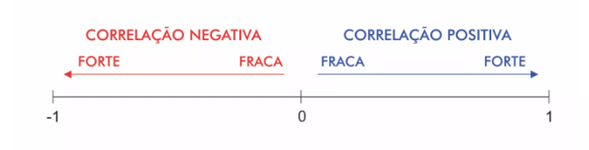

In [ ]:
# Criando a matriz de correlação
corr = df.drop('TARGET', axis=1).corr().abs()

In [ ]:
# Triângulo superior de uma matriz de correlação  
triu_Matriz = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))

# gerando as variáveis perfeitamente correlacionadas maior que 0.95
triu_Matriz = [col for col in triu_Matriz.columns if any(triu_Matriz[col] > 0.95)]

In [ ]:
len(triu_Matriz)

89

In [ ]:
#  DataFrame com as colunas correlacionadas
pd.DataFrame(triu_Matriz, columns=['Corr_Perfect'])

,Corr_Perfect
0,imp_op_var41_comer_ult1
1,imp_op_var41_comer_ult3
2,imp_op_var39_efect_ult1
3,imp_op_var39_efect_ult3
4,imp_op_var39_ult1
...,...
84,saldo_medio_var17_ult3
85,saldo_medio_var29_ult3
86,saldo_medio_var33_ult1
87,saldo_medio_var33_ult3


In [ ]:
# deletando as colunas pefeitamente correlacionadas
df.drop(df[triu_Matriz], axis = 1, inplace=True)

In [ ]:
df.shape

(71213, 187)

# **EDA** - Exploratory Data Analysis

Vamos criar uma função utilizando o Ploty para gerar gráficos interativos

In [ ]:
# Criando uma função para gráficos de barra interativos com o plotly.

def plotBar(x, y, title, yaxis, xaxis, orientation='v'):
    
    # Definindo as configurações do grafico.

    percentual = np.round((target[0]/df.shape[0]*100, target[1]/df.shape[0]*100),decimals=2)
    
    trace = go.Bar(x = x, y = y, opacity = 0.8, orientation = orientation, textposition='outside', text=percentual)

    data = [trace]

    # Definindo as configurações de layout.
    
    layout = go.Layout(
        title       = title,
        yaxis       =  {'title': yaxis},
        xaxis       =  {'title': xaxis},
    )

    # Figure com os dados e o layout definidos.

    fig = go.Figure(data = data, layout = layout)

    fig.show()

### Analisando o balanceamento da nossa variável **TARGET**

In [ ]:
# Verificando o número de cliente em cada classe.
target = df.TARGET.value_counts()
target

0    68398
1     2815
Name: TARGET, dtype: int64

In [ ]:
# Alterando os nomes do índice.
target.index = ['Satisfeito', 'Insatisfeito']
 
# Calculando o percentual
percentual = np.round((target[0]/df.shape[0]*100, target[1]/df.shape[0]*100),decimals=2)
    

fig = px.bar(x=target.index, y= target.values,title='Distribuíçao do Número de clientes',
             orientation='v', text=percentual,
             labels={'x':'Clientes','y':'Número Clientes'})

fig.update_traces(texttemplate='%{text:.2f}%', opacity = 0.65, textposition='outside',
        hoverlabel=dict(
        bgcolor="#f5f5f5",
        font_size=14,
    ),
)

                  
fig.show()

Observa-se um desbalancemento das classes o que pode fazer nosso modelo tender a acertar mais para um determinada classe. No final veremos como utilizar uma técnica para tratar esse problema.

In [ ]:
print("A porcentagem de clientes Insatisfeito é de: {:.2f}%".format(100 * target[1] / df.shape[0]))

A porcentagem de clientes Insatisfeito é de: 3.95%


In [ ]:
# agrupamento da variável "var3"
df.groupby('TARGET')['var3'].sum()

TARGET
0   -104809514
1     -1993696
Name: var3, dtype: int64

In [ ]:
# verificando os valores negativos para variável "var3"
df[df['var3'] < 0]

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_largo_0,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,num_var1,num_var4,num_var5_0,num_var12_0,num_var13_largo_0,num_var14_0,num_var14,...,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_medio_hace2,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,var38,TARGET
782,-999999,33,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
3361,-999999,36,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,3,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0,0,6,0,0,0.00,0.00,1983.00,1983.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
4103,-999999,27,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0,0,0,0,9,90.00,29.04,84.18,67.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
4422,-999999,45,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
7053,-999999,44,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74796,-999999,25,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
74846,-999999,25,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
75012,-999999,39,0.0,451.83,451.83,0.0,0.0,0.0,0.0,0.0,2430.0,2430.0,2881.83,0.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,3,3,0,0,0,0,...,0,0,0,12,12,0,0,0,0,0,0,69,0,12,521.25,0.00,3780.27,2150.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
75783,-

In [ ]:
# verificando a Moda para var3
df.var3.mode()[0]

2

In [ ]:
# substituindo o valor -999999 pela moda (2)
df['var3'] = df['var3'].replace(-999999, 2)

In [ ]:
# print de todas as colunas que possuem valores negativos

print ([f for f in df.columns if df[f][df[f] < 0].shape[0] > 0])

['saldo_var1', 'saldo_var5', 'saldo_var8', 'saldo_var30', 'saldo_var40', 'delta_imp_aport_var13_1y3', 'delta_imp_aport_var17_1y3', 'delta_imp_aport_var33_1y3', 'delta_imp_compra_var44_1y3', 'delta_imp_reemb_var17_1y3', 'delta_imp_trasp_var17_in_1y3', 'delta_imp_trasp_var33_in_1y3', 'delta_imp_venta_var44_1y3', 'saldo_medio_var5_hace2', 'saldo_medio_var5_hace3', 'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3', 'saldo_medio_var8_hace2', 'saldo_medio_var8_ult1', 'saldo_medio_var8_ult3']


# Visualização dos dados de teste

In [ ]:
# verificando o shape dos dados de teste
print("Temos " + str(dataTest.shape[1]) + " Colunas e " + str(dataTest.shape[0]) + " linhas em nosso dados.")

Temos 370 Colunas e 75818 linhas em nosso dados.


In [ ]:
# Eliminando a coluna ID dados de Teste.
dfTest = dataTest.drop('ID', axis=1)

# Salvando o ID da base de teste
test_id = dataTest.ID

In [ ]:
# print shape dos dados de Teste
print(df.shape, dfTest.shape)

(71213, 187) (75818, 369)


In [ ]:
# verificando valores nulos nos dados
df.isnull().sum().any(), dfTest.isnull().sum().any()

(False, False)

In [ ]:
dfTest[dfTest['var3'] < 0]

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,...,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
459,-999999,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,14.01,10.92,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
536,-999999,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,1692.84,1117.38,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
938,-999999,67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5.82,90.00,61.95,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
2678,-999999,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,75.45,90.00,85.14,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
3720,-999999,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.44,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70090,-999999,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,153.00,88.35,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
71044,-999999,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
# Temos 120 linhas que o registro é -999999	nos dados de Teste vamos substituir também pela moda = 2

In [ ]:
# substituindo o valor -999999 pela moda (2)
dfTest['var3'] = dfTest['var3'].replace(-999999, 2)

## Normalização dos dados para Features de treino

In [ ]:
# definindo as variaveis X, y
X_train = df.drop('TARGET', axis = 1)
target = df.TARGET

# MinMaxScaler


In [ ]:
# criando objeto da classe MinMax
MinMax = MinMaxScaler()

# aplicando a normalização nos dados
X_MinMax = MinMax.fit_transform(X_train)

# criando DataFrame

X_MinMax = pd.DataFrame(X_MinMax, columns = X_train.columns)

X_MinMax.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_largo_0,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,num_var1,num_var4,num_var5_0,num_var12_0,num_var13_largo_0,num_var14_0,num_var14,...,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_medio_hace2,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,var38
0,0.008403,0.18,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.2,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000158,0.000005,0.001531,0.000874,0.001242,0.0,0.014697,0.01028,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001545
1,0.008403,0.29,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.142857,0.2,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000158,0.000063,0.001531,0.000874,0.001242,0.0,0.014697,0.01028,0.0,0.0,0.000667,0.000401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002003
2,0.008403,0.18,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.142857,0.2,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000162,0.000005,0.001536,0.000878,0.001242,0.0,0.014697,0.01028,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002822
3,0.008403,0.32,0.0,0.01513,0.009275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004097,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.428571,0.2,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.078947,0.00885,0.035294,0.000387,0.000005,0.001683,0.001129,0.001242,0.0,0.014697,0.01028,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002671
4,0.008403,0.34,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.142857,0.2,0.027027,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016667,0.022727,0.032258,0.0,0.000000,0.00000,0.000000,0.000162,0.000005,0.068770,0.025654,0.001242,0.0,0.014697,0.01028,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005091


# StandardScaler

In [ ]:
# criando objeto da classe StandardScaler
scaler = StandardScaler()

# aplicando a normalização nos dados
X_scaler = scaler.fit_transform(X_train)

# criando DataFrame

X_scaler = pd.DataFrame(X_scaler, columns = X_train.columns)

X_scaler.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_largo_0,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,num_var1,num_var4,num_var5_0,num_var12_0,num_var13_largo_0,num_var14_0,num_var14,...,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_medio_hace2,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,var38
0,-0.078374,-0.805834,-0.055166,-0.220682,-0.226444,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,-0.132561,-0.12319,-0.203502,-0.012161,-0.111276,0.215843,-1.454553,-0.189912,-0.177453,-0.278592,-0.225742,-0.243045,-0.219171,-0.104756,-0.160942,-0.217654,-0.205296,-0.170382,-0.164353,-1.744808,-0.289191,-0.273643,0.360589,-0.06339,-1.227303,0.166486,-0.245519,-0.095309,-0.123018,-0.074375,...,-0.037079,-0.034897,-0.017454,-0.018766,-0.23188,-0.243149,-0.012416,-0.032894,-0.183357,-0.237098,-0.106412,-0.017281,-0.385938,-0.387333,-0.313837,-0.134336,-0.093141,-0.115755,-0.132341,-0.040688,-0.018909,-0.058394,-0.058747,-0.109361,-0.068224,-0.142747,-0.080022,-0.060917,-0.03566,-0.061776,-0.005232,-0.005264,-0.003747,-0.005037,-0.017986,-0.012377,-0.01617,-0.012994,-0.019442,-0.414017
1,-0.078374,0.033327,-0.055166,-0.220682,-0.226444,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,-0.132561,-0.12319,-0.203502,-0.012161,-0.111276,0.215843,-1.454553,-0.189912,-0.177453,-0.278592,-0.225742,4.114456,4.562643,-0.104756,-0.160942,-0.217654,-0.205296,-0.170382,-0.164353,0.573129,-0.289191,-0.273643,0.360589,-0.06339,-0.134175,0.166486,-0.245519,-0.095309,-0.123018,-0.074375,...,-0.037079,-0.034897,-0.017454,-0.018766,-0.23188,-0.243149,-0.012416,-0.032894,-0.183357,-0.237098,-0.106412,-0.017281,-0.385938,-0.387333,-0.313837,-0.134336,-0.084438,-0.115755,-0.132341,-0.040688,-0.018909,-0.058394,-0.058747,-0.109361,-0.068224,-0.131724,-0.063549,-0.060917,-0.03566,-0.061776,-0.005232,-0.005264,-0.003747,-0.005037,-0.017986,-0.012377,-0.01617,-0.012994,-0.019442,-0.360503
2,-0.078374,-0.805834,-0.055166,-0.220682,-0.226444,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,-0.132561,-0.12319,-0.203502,-0.012161,-0.111276,0.215843,0.687496,-0.189912,-0.177453,-0.278592,-0.225742,-0.243045,-0.219171,-0.104756,-0.160942,-0.217654,-0.205296,-0.170382,-0.164353,0.573129,-0.289191,-0.273643,0.360589,-0.06339,-0.134175,0.166486,-0.245519,-0.095309,-0.123018,-0.074375,...,-0.037079,-0.034897,-0.017454,-0.018766,-0.23188,-0.243149,-0.012416,-0.032894,-0.183357,-0.237098,-0.106412,-0.017281,-0.385938,-0.387333,-0.313837,-0.134097,-0.093123,-0.115453,-0.132096,-0.040688,-0.018909,-0.058394,-0.058747,-0.109361,-0.068224,-0.142747,-0.080022,-0.060917,-0.03566,-0.061776,-0.005232,-0.005264,-0.003747,-0.005037,-0.017986,-0.012377,-0.01617,-0.012994,-0.019442,-0.264577
3,-0.078374,0.262189,-0.055166,0.336397,0.119616,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,-0.13256

# PowerTransformer

In [ ]:
# criando objeto da classe PowerTransformer
powerScaler = PowerTransformer()

# aplicando nos dados
X_TrainPower = powerScaler.fit_transform(X_scaler)

# criando DataFrame
X_TrainPower = pd.DataFrame(X_TrainPower, columns= X_train.columns)
X_TrainPower

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_largo_0,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,num_var1,num_var4,num_var5_0,num_var12_0,num_var13_largo_0,num_var14_0,num_var14,...,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_medio_hace2,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,var38
0,-0.081263,-1.037083,-0.227166,-0.386862,-0.416585,-0.064496,-0.070075,-0.023106,-0.025146,-0.056799,-0.319955,-0.362865,-0.417223,-0.036731,-0.111276,0.215843,-1.454553,-0.189912,-0.177453,-0.278592,-0.225742,-0.243045,-0.219171,-0.104756,-0.160942,-0.217654,-0.205296,-0.170382,-0.164353,-1.744808,-0.289191,-0.273643,0.360589,-0.063501,-1.480731,0.10742,-0.278592,-0.104756,-0.160942,-0.075441,...,-0.064496,-0.070077,-0.023106,-0.025146,-0.321840,-0.371741,-0.016761,-0.036741,-0.276626,-0.400146,-0.153341,-0.024865,-0.726844,-0.705258,-0.631784,-0.499204,-0.383015,-0.533018,-0.534858,-0.114805,-0.080288,-0.124899,-0.134181,-0.199848,-0.13123,-0.206536,-0.138857,-0.083062,-0.064824,-0.087165,-0.0053,-0.007495,-0.003747,-0.006491,-0.02458,-0.018361,-0.037039,-0.021202,-0.044234,-1.615952
1,-0.081263,0.454495,-0.227166,-0.386862,-0.416585,-0.064496,-0.070075,-0.023106,-0.025146,-0.056799,-0.319955,-0.362865,-0.417223,-0.036731,-0.111276,0.215843,-1.454553,-0.189912,-0.177453,-0.278592,-0.225742,4.114456,4.562643,-0.104756,-0.160942,-0.217654,-0.205296,-0.170382,-0.164353,0.573129,-0.289191,-0.273643,0.360589,-0.063501,0.033303,0.10742,-0.278592,-0.104756,-0.160942,-0.075441,...,-0.064496,-0.070077,-0.023106,-0.025146,-0.321840,-0.371741,-0.016761,-0.036741,-0.276626,-0.400146,-0.153341,-0.024865,-0.726844,-0.705258,-0.631784,-0.499204,0.251350,-0.533018,-0.534858,-0.114805,-0.080288,-0.124899,-0.134181,-0.199848,-0.13123,0.645891,3.358682,-0.083062,-0.064824,-0.087165,-0.0053,-0.007495,-0.003747,-0.006491,-0.02458,-0.018361,-0.037039,-0.021202,-0.044234,-1.261795
2,-0.081263,-1.037083,-0.227166,-0.386862,-0.416585,-0.064496,-0.070075,-0.023106,-0.025146,-0.056799,-0.319955,-0.362865,-0.417223,-0.036731,-0.111276,0.215843,0.687496,-0.189912,-0.177453,-0.278592,-0.225742,-0.243045,-0.219171,-0.104756,-0.160942,-0.217654,-0.205296,-0.170382,-0.164353,0.573129,-0.289191,-0.273643,0.360589,-0.063501,0.033303,0.10742,-0.278592,-0.104756,-0.160942,-0.075441,...,-0.064496,-0.070077,-0.023106,-0.025146,-0.321840,-0.371741,-0.016761,-0.036741,-0.276626,-0.400146,-0.153341,-0.024865,-0.726844,-0.705258,-0.631784,-0.489342,-0.381624,-0.519730,-0.525754,-0.114805,-0.080288,-0.124899,-0.134181,-0.199848,-0.13123,-0.206536,-0.138857,-0.083062,-0.064824,-0.087165,-0.0053,-0.007495,-0.003747,-0.006491,-0.02458,-0.018361,-0.037039,-0.021202,-0.044234,-0.699327
3,-0.081263,0.691982,-0.227166,2.733548,2.376373,-0.064496,-0.070075,-0.023106,-0.025146,-0.056799,-0.319955

# Tratamento dados de teste

In [ ]:
# definindo as variaveis dos dados de Teste
X_test = dfTest[list(X_train.loc[:,])]

# Print 
X_test

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_largo_0,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,num_var1,num_var4,num_var5_0,num_var12_0,num_var13_largo_0,num_var14_0,num_var14,...,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_medio_hace2,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,var38
0,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,2.43,6.00,4.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,40532.100000
1,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,3.0,2.55,3.00,2.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,45486.720000
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,60.0,60.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,3,0,0,0,0,...,0,0,0,0,3,3,0,0,0,0,0,0,3,6,0,90.0,57.00,51.45,66.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,46993.950000
3,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,187898.610000
4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30.0,3.87,30.00,21.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,73649.730000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75813,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,40243.200000
75814,2,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,1.23,3.00,2.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,146961.300000
75815,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90.0,29.04,90.00,69.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,167299.770000
75816,2,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,3,0,0,0,0,...,0,0,0,0,0,0

Mantemos 186 colunas em nosso dados de Teste conforme dados de Treino. O dados de teste possui 75.818. Esses dados nos iremos enviar para Submissão no Kaggle e verificar o Score, pois não temos a variavel Target desses dados.

# MinMaxScaler dados de teste

In [ ]:
# aplicando a normalização nos dados
X_test_MinMax = MinMax.transform(X_test)

# criando DataFrame
X_test_MinMax = pd.DataFrame(X_test_MinMax, columns=X_test.columns)

# print 5 primeiras linhas
X_test_MinMax.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_largo_0,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,num_var1,num_var4,num_var5_0,num_var12_0,num_var13_largo_0,num_var14_0,num_var14,...,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_medio_hace2,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,var38
0,0.008403,0.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.142857,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000165,0.000007,0.001541,0.000883,0.001242,0.0,0.014697,0.01028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001605
1,0.008403,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.142857,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.017699,0.0,0.000162,0.000007,0.001536,0.000879,0.001242,0.0,0.014697,0.01028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001830
2,0.008403,0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001305,0.000458,0.001261,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.285714,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.033333,0.019231,0.0,0.0,0.0,0.0,0.0,0.0,0.008772,0.017699,0.0,0.000269,0.000042,0.001617,0.000995,0.001242,0.0,0.014697,0.01028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001899
3,0.008403,0.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000158,0.000005,0.001531,0.000874,0.001242,0.0,0.014697,0.01028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008295
4,0.008403,0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.142857,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000195,0.000008,0.001581,0.000913,0.001242,0.0,0.014697,0.01028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003109


# StandardScaler dados de teste

In [ ]:
# aplicando a normalização nos dados
scalerTest = scaler.transform(X_test)

# criando DataFrame
X_Testscaler = pd.DataFrame(scalerTest, columns = X_test.columns)

# print 5 primeiras linhas
X_Testscaler.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_largo_0,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,num_var1,num_var4,num_var5_0,num_var12_0,num_var13_largo_0,num_var14_0,num_var14,...,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_medio_hace2,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,var38
0,-0.078374,-0.119248,-0.055166,-0.220682,-0.226444,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,-0.132561,-0.123190,-0.203502,-0.012161,-0.111276,0.215843,0.687496,-0.189912,-0.177453,-0.278592,-0.225742,-0.243045,-0.219171,-0.104756,-0.160942,-0.217654,-0.205296,-0.170382,-0.164353,0.573129,-0.289191,-0.273643,0.360589,-0.06339,-0.134175,0.166486,-0.245519,-0.095309,-0.123018,-0.074375,...,-0.037079,-0.034897,-0.017454,-0.018766,-0.231880,-0.243149,-0.012416,-0.032894,-0.183357,-0.237098,-0.106412,-0.017281,-0.385938,-0.387333,-0.313837,-0.133858,-0.092903,-0.115151,-0.131773,-0.040688,-0.018909,-0.058394,-0.058747,-0.109361,-0.068224,-0.142747,-0.080022,-0.060917,-0.03566,-0.061776,-0.005232,-0.005264,-0.003747,-0.005037,-0.017986,-0.012377,-0.01617,-0.012994,-0.019442,-0.406968
1,-0.078374,0.109614,-0.055166,-0.220682,-0.226444,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,-0.132561,-0.123190,-0.203502,-0.012161,-0.111276,0.215843,0.687496,-0.189912,-0.177453,-0.278592,-0.225742,-0.243045,-0.219171,-0.104756,-0.160942,-0.217654,-0.205296,-0.170382,-0.164353,0.573129,-0.289191,-0.273643,-2.773242,-0.06339,-0.134175,0.166486,-0.245519,-0.095309,-0.123018,-0.074375,...,-0.037079,-0.034897,-0.017454,-0.018766,-0.231880,-0.243149,-0.012416,-0.032894,-0.183357,-0.237098,-0.106412,-0.017281,-0.385938,0.172720,-0.313837,-0.134097,-0.092891,-0.115453,-0.132004,-0.040688,-0.018909,-0.058394,-0.058747,-0.109361,-0.068224,-0.142747,-0.080022,-0.060917,-0.03566,-0.061776,-0.005232,-0.005264,-0.003747,-0.005037,-0.017986,-0.012377,-0.01617,-0.012994,-0.019442,-0.380645
2,-0.078374,-0.805834,-0.055166,-0.220682,-0.226444,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,-0.023321,-0.062037,-0.120160,-0.012161,-0.111276,0.215843,0.687496,-0.189912,-0.177453,-0.278592,-0.225742,-0.243045,-0.219171,-0.104756,-0.160942,-0.217654,-0.205296,-0.170382,-0.164353,0.573129,-0.289191,-0.273643,0.360589,-0.06339,0.958952,0.166486,-0.245519,-0.095309,-0.123018,-0.074375,...,-0.037079,-0.034897,-0.017454,-0.018766,0.673929,0.320576,-0.012416,-0.032894,-0.183357,-0.237098,-0.106412,-0.017281,-0.184705,0.172720,-0.313837,-0.127162,-0.087561,-0.110574,-0.124519,-0.040688,-0.018909,-0.058394,-0.058747,-0.109361,-0.068224,-0.142747,-0.080022,-0.060917,-0.03566,-0.061776,-0.005232,-0.005264,-0.003747,-0.005037,-0.017986,-0.012377,-0.01617,-0.012994,-0.019442,-0.372637
3,-0.078374,-0.729547,-0.055166,-0.220682,-0.226444,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,-0.1

#Features Selection

In [ ]:
# divisão da base para gerar Features Selection
XTrain, XTest, yTrain, yTest = train_test_split(X_train, target, test_size = 0.2, stratify = target, random_state = 41)

kv_score_fc = []
kv_score_mic = []

start = time.time()
for k in range(2, 20, 2):

  selector_fc = SelectKBest(score_func=f_classif, k=k)
  selector_mic = SelectKBest(score_func=mutual_info_classif, k=k)

  X_train_selector_fc = selector_fc.fit_transform(XTrain, yTrain)
  X_train_selector_mic = selector_mic.fit_transform(XTrain, yTrain)

  model = XGBClassifier(random_state=42)

  # cv = 10
  auc_fc = cross_val_score(model, X_train_selector_fc, yTrain, cv=10, scoring= 'roc_auc')
  auc_mic = cross_val_score(model, X_train_selector_mic, yTrain, cv=10, scoring= 'roc_auc')

  kv_score_fc.append(auc_fc.mean())
  kv_score_mic.append(auc_mic.mean())

  end = time.time()

  print("K = {} - auc_fc = {} - auc_mic = {} - Time = {:.2f}s".format(k, auc_fc.mean(), auc_mic.mean(), end-start))

print("Tempo total treinamento: ", round(time.time() - start, 3))

K = 2 - auc_fc = 0.6876166143005791 - auc_mic = 0.6906737693432935 - Time = 107.51s
K = 4 - auc_fc = 0.6982653224870923 - auc_mic = 0.6982653224870923 - Time = 217.56s
K = 6 - auc_fc = 0.708294784424273 - auc_mic = 0.7249924104066657 - Time = 332.23s
K = 8 - auc_fc = 0.7983585638342735 - auc_mic = 0.8176301152233496 - Time = 451.33s
K = 10 - auc_fc = 0.8012453131262692 - auc_mic = 0.81838445599182 - Time = 574.41s
K = 12 - auc_fc = 0.8187946543217322 - auc_mic = 0.8185561392156174 - Time = 702.02s
K = 14 - auc_fc = 0.8188295784309766 - auc_mic = 0.8191083211485275 - Time = 833.41s
K = 16 - auc_fc = 0.8195895080643698 - auc_mic = 0.82305613579917 - Time = 968.89s
K = 18 - auc_fc = 0.8218184165113558 - auc_mic = 0.8227257350695181 - Time = 1107.06s
Tempo total treinamento:  1107.057


O código acima retorna duas listas com K-Scores. Traçando-os para cada valor de K, podemos escolher o melhor valor K, bem como os melhores recursos.

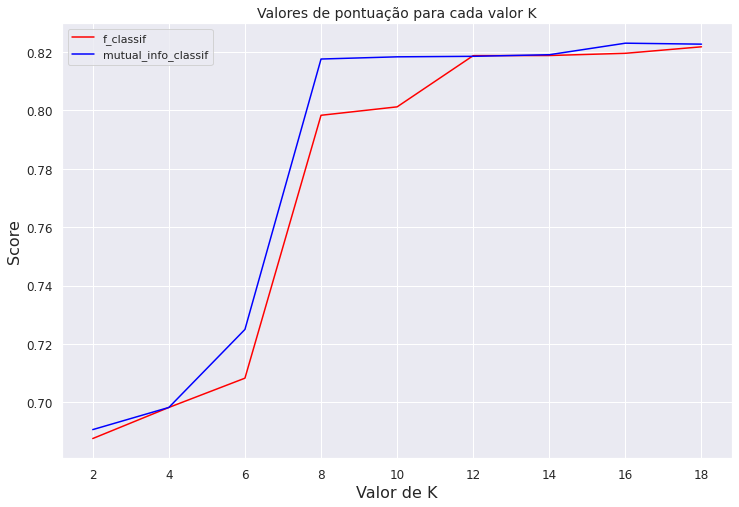

In [ ]:
# Plot dos Valores de pontuação para cada valor K
plt.figure(figsize=(12,8))
plt.plot(np.arange(2,20,2), kv_score_fc, color = 'red', label = 'f_classif')
plt.plot(np.arange(2,20,2), kv_score_mic, color = 'blue', label = 'mutual_info_classif')
plt.legend()
plt.title('Valores de pontuação para cada valor K', fontsize=14)
plt.xlabel('Valor de K', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

## Vamos plotar as 30 melhores variáveis com K-Score

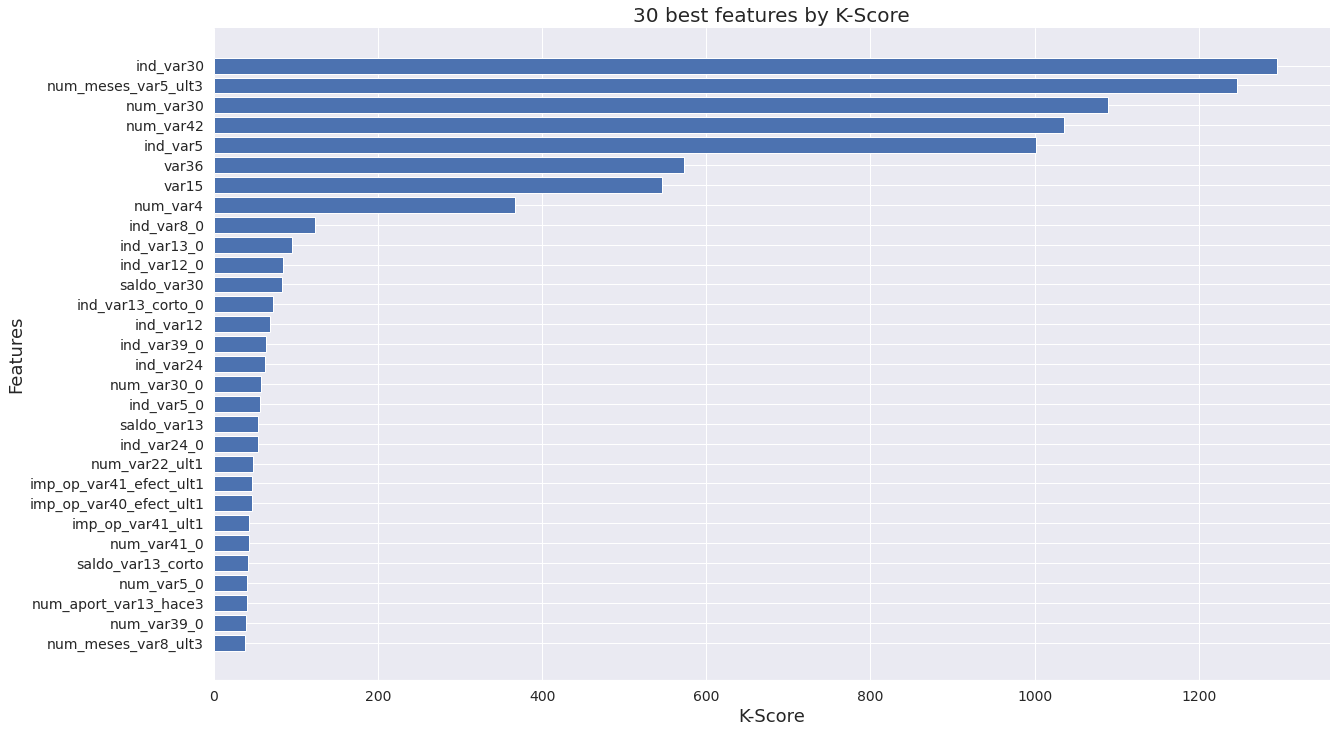

In [ ]:
feature_score = pd.Series(selector_fc.scores_, 
index = X_train.columns).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(20, 12))
ax.barh(feature_score.index[0:30], feature_score[0:30])
plt.gca().invert_yaxis()
ax.set_xlabel('K-Score', fontsize=18);
ax.set_ylabel('Features', fontsize=18);
ax.set_title('30 best features by K-Score', fontsize = 20)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False);

## **SelectKBest**

Selecione os recursos de acordo com as k pontuações mais altas.


**chi2** - Calcule estatísticas qui-quadradas entre cada característica e classe não negativa. Esta pontuação pode ser usada para selecionar os recursos n_features com os valores mais altos para a estatística de teste qui-quadrado de X, que deve conter apenas recursos não negativos

Vimos acima que com 8 Atributos tivemos um desempenho muito bom. Acima de 8 aumento de performace não foi tão significante, dessa forma iremos trabalhar com SelectKBest utilizando 8 Variáveis.

In [ ]:
# instanciando objeto para 8 melhores variaveis k=8
skb = SelectKBest(chi2, k=8)

# fit dos dados
skchi2 = skb.fit_transform(X_MinMax, target)

# pegando o nome das variáriveis

skchi2 = X_train.columns[skb.get_support()]
# Print das 8  melhores variaveis
skchi2

Index(['ind_var5', 'ind_var8_0', 'ind_var12_0', 'ind_var13_0',
       'ind_var13_corto_0', 'ind_var30', 'var36', 'num_meses_var5_ult3'],
      dtype='object')

In [ ]:
# vamos criar um DataFrame com os Scores obtidos
df_bestChi2 = pd.DataFrame(skb.scores_, index= X_train.columns, columns=['Score'])

# pegando as melhores variáveis
df_bestChi2 = df_bestChi2[skb.get_support()]

# sort values
df_bestChi2 = df_bestChi2.sort_values(by='Score', ascending=False)

In [ ]:
# plot gráfico de barras do metódo Selectkbest, chi2 com os 8 maiores Scores.

plotBar(x = df_bestChi2.Score, y = df_bestChi2.index, title = "SelectKBest \"chi2\" best Features.",
        yaxis = 'Features', xaxis = 'Score', orientation = 'h')

## ANOVA F-value

Se os recursos forem categóricos, calcularemos uma estatística qui-quadrado entre cada recurso e o vetor de destino. No entanto, se os recursos forem quantitativos, calcularemos o valor ANOVA F entre cada recurso e o vetor de destino.

As pontuações do valor F examinam se, quando agrupamos a característica numérica pelo vetor alvo, as médias para cada grupo são significativamente diferentes.

In [ ]:
#Criando um objeto SelectKBest para selecionar características com as 8 melhores ANOVA F-Values
skb = SelectKBest(f_classif, k=8)

# Aplicando o objeto SelectKBest as variáveis e target
skAN = skb.fit_transform(X_MinMax, target)

# pegando o nome das variáriveis
skAN = X_train.columns[skb.get_support()]

# Print das 8  melhores variaveis
skAN

Index(['var15', 'ind_var5', 'ind_var30', 'num_var4', 'num_var30', 'num_var42',
       'var36', 'num_meses_var5_ult3'],
      dtype='object')

In [ ]:
# vamos criar um DataFrame com os Scores obtidos para ANOVA
df_bestAN = pd.DataFrame(skb.scores_, index= X_train.columns, columns=['Score'])

# pegando as melhores variáveis
df_bestAN = df_bestAN[skb.get_support()]

# sort values
df_bestAN = df_bestAN.sort_values(by='Score', ascending=False)

In [ ]:
# plot gráfico de barras do metódo Selectkbest, ANOVA F-value com os 8 maiores Scores.

plotBar(x = df_bestAN.Score, y = df_bestAN.index, title = "SelectKBest \"ANOVA F-value\" best Features.",
        yaxis = 'Features', xaxis = 'Score', orientation = 'h')

## RandomForest

RandomForest e dos algoritmos de Machine Learning mais populares. Eles são muito bem-sucedidos porque fornecem, em geral, um bom desempenho preditivo, baixo overfitting e fácil interpretabilidade. Essa interpretabilidade é dada pelo fato de que é simples derivar a importância de cada variável na decisão da árvore. Em outras palavras, é fácil calcular o quanto cada variável está contribuindo para a decisão.

O RandomForest consistem em 4-12 centenas de árvores de decisão, cada uma delas construída sobre uma extração aleatória das observações do conjunto de dados e uma extração aleatória das características. Nem toda árvore vê todas as características ou todas as observações, e isso garante que as árvores sejam descorrelacionadas e, portanto, menos sujeitas a sobreajuste. Cada árvore também é uma sequência de perguntas sim-não com base em um único recurso ou em uma combinação de recursos. Em cada nó (isso é em cada questão), o três divide o conjunto de dados em 2 depósitos, cada um deles hospedando observações que são mais semelhantes entre si e diferentes das do outro grupo. Portanto, a importância de cada recurso é derivada de quão "puro" cada um dos baldes é.

Para classificação, a medida de impureza é a impureza de Gini ou o ganho / entropia de informação. Para regressão, a medida de impureza é a variância. Portanto, ao treinar uma árvore, é possível calcular o quanto cada recurso diminui a impureza. Quanto mais um recurso diminui a impureza, mais importante ele é.

os recursos selecionados no topo das árvores são em geral mais importantes do que os recursos selecionados nos nós finais das árvores, pois geralmente as divisões superiores levam a maiores ganhos de informação.


feature_importances_ são baseado em impurezas.
Quanto mais alto, mais importante é o recurso. A importância de um recurso é calculada como a redução total (normalizada) do critério trazido por esse recurso. É também conhecida como a importância Gini. Os critérios suportados são “gini” para a impureza de Gini e “entropia” para o ganho de informação

In [ ]:
# Instanciando um objeto da classe RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0, criterion='gini')

# Treinando o modelo normalizado com os dados de treino.
rf.fit(X_MinMax, target)

# Fazendo previsão.
pred = rf.predict(X_MinMax)

# verificando o score
score = accuracy_score(target, pred)
print(score)

In [ ]:
# criando DataFrame
rf_importances = pd.DataFrame(data=rf.feature_importances_ ,index=X_MinMax.columns, columns=['Score'])

# selecionando as 8 melhores Features
rf_importances = rf_importances.nlargest(8, columns=['Score'])

# pegando index das melhores Features
rfbest = rf_importances.index

# plot do gráfico de barras com os 8 maiores Scores.

plotBar(y = rf_importances.index,
        x = rf_importances.Score.values,
        title = "Score com as Melhores best com RandomForest",
        yaxis = 'Features',
        xaxis='Scores',
        orientation='h')

##**RFE** - Recursive Feature elimination 
O objetivo da eliminação recursiva de recursos (RFE) é selecionar recursos considerando recursivamente conjuntos cada vez menores. Primeiro, o estimador é treinado no conjunto inicial de características e a importância de cada característica é obtida por meio de um coef_atributo ou por meio de um feature_importances_atributo. Em seguida, os recursos menos importantes são removidos do conjunto atual. Esse procedimento é repetido recursivamente no conjunto de dados até que o número desejado de recursos a serem selecionados seja atingido.

RFE é um algoritmo de otimização guloso que visa encontrar o subconjunto de recursos de melhor desempenho. Ele cria modelos repetidamente e mantém de lado o recurso de melhor ou pior desempenho em cada iteração. Ele constrói o próximo modelo com os recursos à esquerda até que todos os recursos sejam exauridos. Em seguida, ele classifica os recursos com base na ordem de eliminação.


In [ ]:
# Instanciando um objeto da classe RFE
# Iremos utlizar o modelo GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100, random_state=0)

rfe = RFE(estimator=model, n_features_to_select=8)

# Treinando o modelo normalizado com os dados de treino.
rfe.fit(X_MinMax, target)

# Fazendo previsão.
predrfe = rfe.predict(X_MinMax)

pred_rfe = X_MinMax.columns[rfe.support_]

# Print das 8  melhores variaveis
pred_rfe

# Avaliação dos Resultados

In [ ]:
# lista com todos os resultados
bestVar = [skchi2.values, skAN.values, rfbest.values, pred_rfe.values]

# criando um DataFrame da lista gerada
bestVar = pd.DataFrame(data= [sorted(x) for x in bestVar],
                       index= ['chi2','anova','rfbest', 'rfe'],
                       columns = ['importances'+ str(i) for i in range(1, bestVar[1].shape[0] + 1)])
bestVar

,importances1,importances2,importances3,importances4,importances5,importances6,importances7,importances8
chi2,ind_var12_0,ind_var13_0,ind_var13_corto_0,ind_var30,ind_var5,ind_var8_0,num_meses_var5_ult3,var36
anova,ind_var30,ind_var5,num_meses_var5_ult3,num_var30,num_var4,num_var42,var15,var36
rfbest,num_var45_hace2,num_var45_hace3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult3,saldo_var30,var15,var38
rfe,imp_op_var41_efect_ult1,ind_var30,num_meses_var5_ult3,num_var4,saldo_medio_var5_ult1,saldo_var30,var15,var38


In [ ]:
# verificando o número de ocorrência para cada Feature
bestVar.melt().value.value_counts()

num_meses_var5_ult3        3
ind_var30                  3
var15                      3
var38                      2
num_var4                   2
ind_var5                   2
var36                      2
saldo_var30                2
ind_var13_corto_0          1
imp_op_var41_efect_ult1    1
saldo_medio_var5_ult1      1
num_var42                  1
num_var30                  1
saldo_medio_var5_hace2     1
ind_var13_0                1
ind_var8_0                 1
saldo_medio_var5_ult3      1
num_var45_hace2            1
num_var45_hace3            1
ind_var12_0                1
saldo_medio_var5_hace3     1
Name: value, dtype: int64

## Histograma

Vamos Gerar um histograma para cada Variável


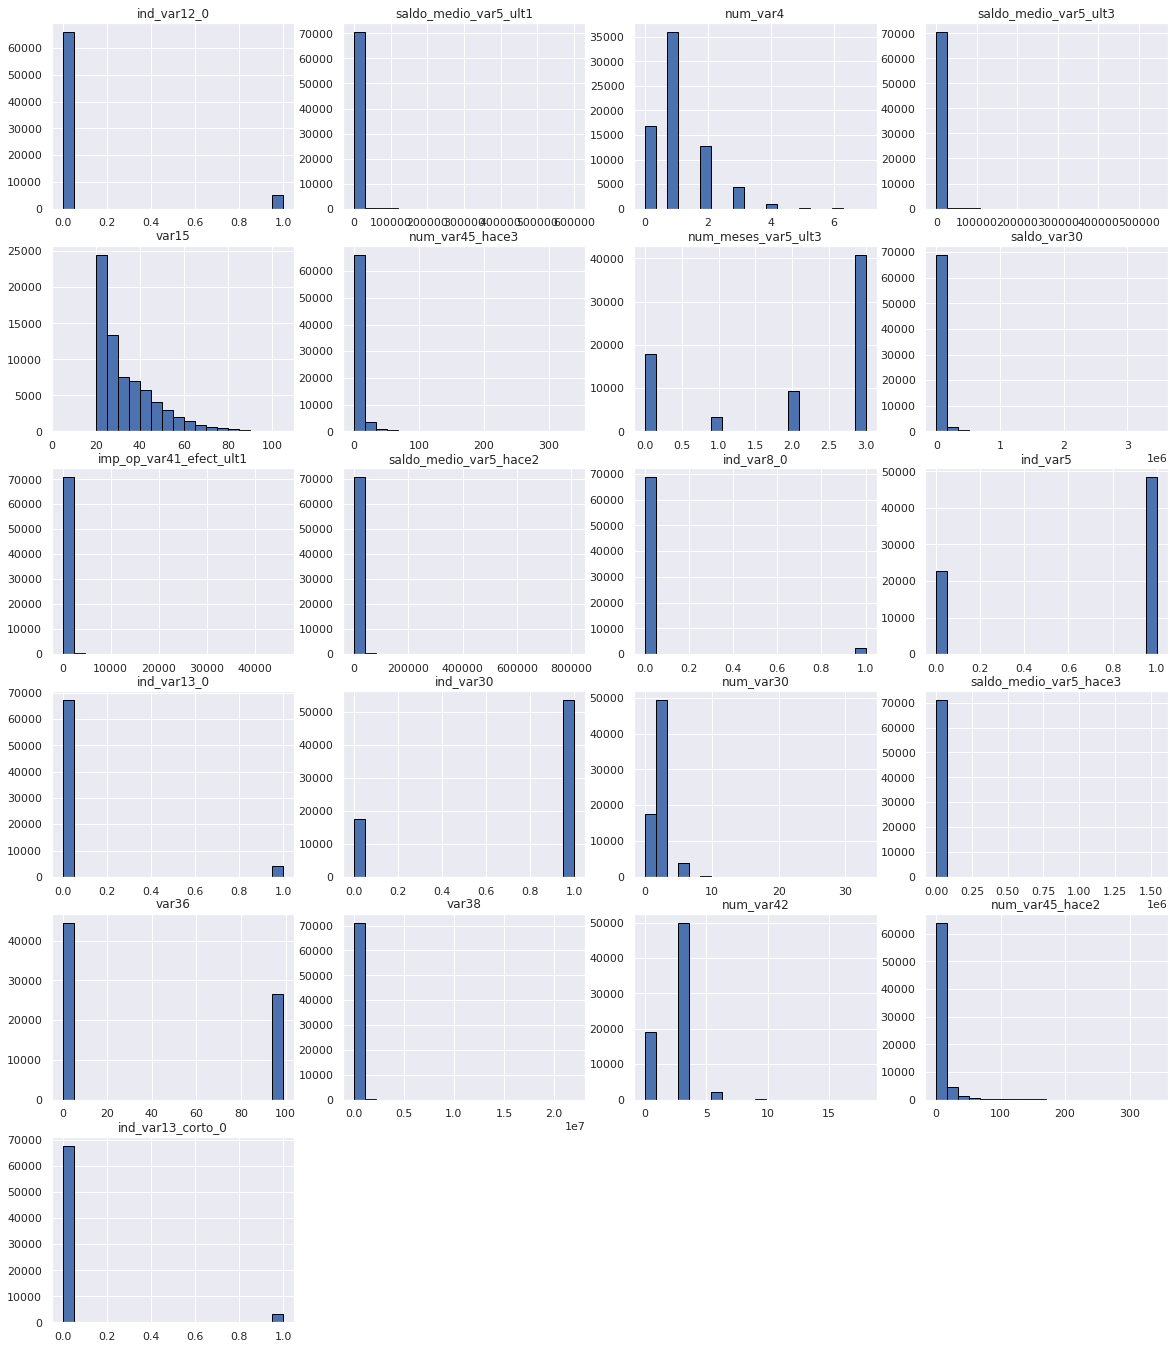

In [ ]:
# gerando histograma das principais variáveis em cada metódo.

columns = [col if col in df.columns else col for col in best]

length = len(columns)
plt.subplots(figsize=(20,28))
for i,j in zip(columns, range(length)):
  
    plt.subplot((length/3),4,1+j)
    df[i].hist(bins=20, edgecolor = 'black')
    
    plt.title(i)

plt.show()

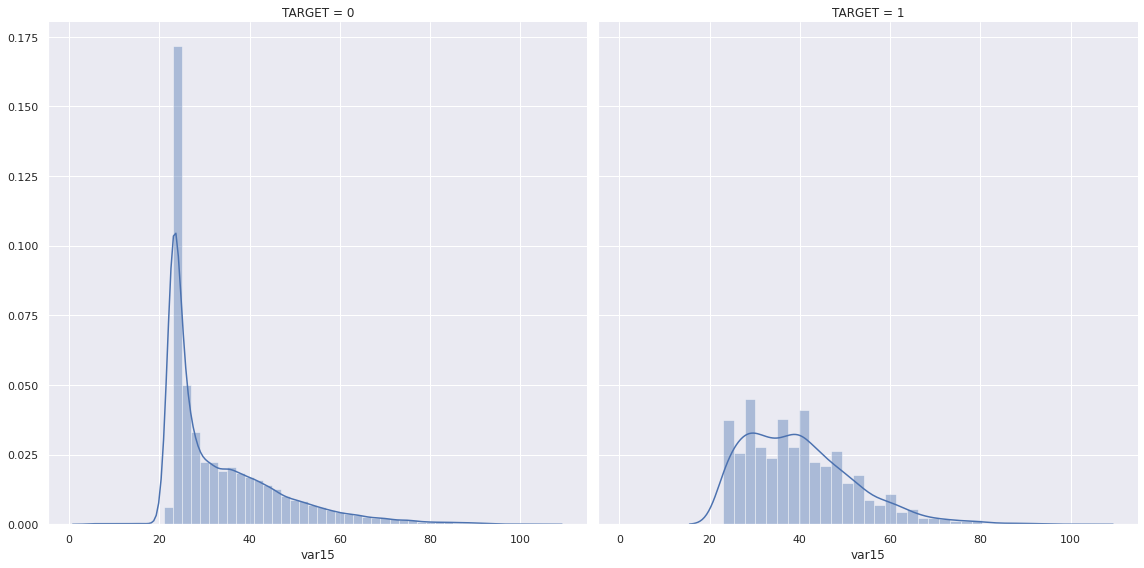

In [ ]:
sns.FacetGrid(df, col='TARGET', height=8).map(sns.distplot, "var15")
plt.show();

Observamos que a variável var15 é Idade dos clientes, embora não seja informado pelo problema. Podemos notar que não temos um distribuição normal dos dados. A menor idade é de 5 anos e a maior Idade 105 anos.

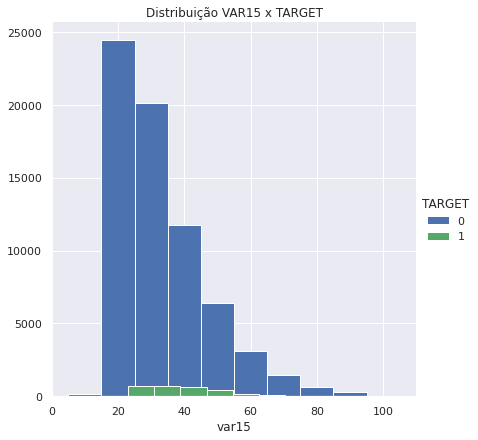

In [ ]:
# Distribuição var15 (idade) x Target
sns.FacetGrid(df, hue='TARGET', height=6).map(plt.hist,'var15').add_legend()
plt.title("Distribuição VAR15 x TARGET")
plt.show();

# Salvando arquivo que iremos utilizar para nosso Modelo.

In [ ]:
# Salvando DataFrame com as melhores variáveis
#bestVar.to_csv('/content/drive/My Drive/Colab Notebooks/Santander/bestVar.csv')

## Carregando Arquivo.

In [ ]:
# Carregando o dataFrame
df_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Santander/bestVar.csv', index_col=0)

In [ ]:
df_data

,importances1,importances2,importances3,importances4,importances5,importances6,importances7,importances8
chi2,ind_var12_0,ind_var13_0,ind_var13_corto_0,ind_var30,ind_var5,ind_var8_0,num_meses_var5_ult3,var36
anova,ind_var30,ind_var5,num_meses_var5_ult3,num_var30,num_var4,num_var42,var15,var36
rfbest,num_var45_hace2,num_var45_hace3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult3,saldo_var30,var15,var38
rfe,imp_op_var41_efect_ult1,ind_var30,num_meses_var5_ult3,num_var4,saldo_medio_var5_ult1,saldo_var30,var15,var38


### Vamos Criar uma função para plot dos modelos de Classificação

In [ ]:
def boxplot(data, title = "Modelos de Classificação", xaxis = "Modelo", yaxis = "Acurácia", opacity = 0.8):


  data = [go.Box(y = data[i], name = i) for i in data.columns]

  layout = go.Layout(
    title =  title,
    xaxis = {"title": xaxis},
    yaxis = {"title" : yaxis} 
)

  fig = go.Figure(data = data, layout = layout)

  fig.show()

# Criando uma função para treinar vários algoritimos

In [ ]:
# Criando uma função para treinar vários algoritimos
def modelos(X, y, msg = True, scoring = 'accuracy', prints = True):

  start = timeit.default_timer()
  prints = print("Iniciando o treinamento dos modelos...\n")
  # Definindo valores para Fold e Seed
  num_folds = 10
  seed = 123
  # criando uma lista para armazenar os modelos
  modelos = []

  # Adicionando os modelos na lista

  modelos.append(('LR', LogisticRegression()))
  modelos.append(('RF', RandomForestClassifier()))
  modelos.append(('KNN', KNeighborsClassifier())) 
  modelos.append(('GBC', GradientBoostingClassifier()))
  modelos.append(('XGB', XGBClassifier()))
  modelos.append(('SVC', SVC()))

  # Criando uma lista para armazenar o nome os valores de cada modelo

  result = []
  names = []

  # Criando DataFrame para armazenar a média e desvio padrão

  df_values = pd.DataFrame(columns = ['mean', 'std'])
  
  # loop por cada modelo na lista de modelos

  for nome, modelo in modelos:

    # Instanciando Kfold
    kfold = KFold(n_splits = num_folds, random_state = seed)
    
    # Cross validation para treinar o modelo
    result_cv = cross_val_score(modelo, X, y, cv = kfold, scoring = scoring)

    # Adicionando o resulta na lista
    result.append(result_cv)
    # Acionando os nomes na lista
    names.append(nome)

    # DataFrame com valores da média
    df_values = df_values.append(
        pd.DataFrame(
            data= [[result_cv.mean(), result_cv.std()]],
            columns = ['mean','std'],
            index = [nome]
            
            )
    )

    if msg:
      print("Modelo: {} - Mean: {:.5f} - std: {:.5f}".format(nome, result_cv.mean(), result_cv.std()))
      
  # DataFrame com os resultados 
  df_result = pd.DataFrame(np.transpose(result), columns=names)
  
  prints = print("\nFinalizado! Tempo em Segundos", np.round(timeit.default_timer() - start, decimals= 3))

  return (df_result, df_values)

## Vamos treinar o modelo utilizando o **MinMax Scaler**

Vamor treinar com cada uma das técnicas utilizadas acima e varemos avaliação de qual tem melhor acuracia.

In [ ]:
# treinanto o modelo com o chi2
modelo_chi2 = modelos(X = X_MinMax[list(df_data.loc['chi2'])],
              y = target)

Iniciando o treinamento dos modelos...

Modelo: LR - Mean: 0.96047 - std: 0.00249
Modelo: RF - Mean: 0.96044 - std: 0.00250
Modelo: KNN - Mean: 0.96022 - std: 0.00278
Modelo: GBC - Mean: 0.96046 - std: 0.00251
Modelo: XGB - Mean: 0.96047 - std: 0.00249
Modelo: SVC - Mean: 0.96047 - std: 0.00249

Finalizado! Tempo em Segundos 268.47


In [ ]:
# Plot da acurácia dos modelos
boxplot(modelo_chi2[0], title = "Modelos de Classificação - Técnica chi2")

In [ ]:
# treinanto o modelo com o Anova
modelo_anova = modelos(X = X_MinMax[list(df_data.loc['anova'])],
              y = target)

Iniciando o treinamento dos modelos...

Modelo: LR - Mean: 0.96048 - std: 0.00248
Modelo: RF - Mean: 0.95879 - std: 0.00259
Modelo: KNN - Mean: 0.95925 - std: 0.00267
Modelo: GBC - Mean: 0.96044 - std: 0.00250
Modelo: XGB - Mean: 0.96047 - std: 0.00249
Modelo: SVC - Mean: 0.96047 - std: 0.00249

Finalizado! Tempo em Segundos 254.812


In [ ]:
# Plot da acurácia dos modelos
boxplot(modelo_anova[0], title = "Modelos de Classificação - Técnica Anova")

In [ ]:
# treinanto o modelo com RandomForest
modelo_rfbest = modelos(X = X_MinMax[list(df_data.loc['rfbest'])],
              y = target)

Iniciando o treinamento dos modelos...

Modelo: LR - Mean: 0.96047 - std: 0.00249
Modelo: RF - Mean: 0.95195 - std: 0.00194
Modelo: KNN - Mean: 0.95692 - std: 0.00243
Modelo: GBC - Mean: 0.96020 - std: 0.00263
Modelo: XGB - Mean: 0.96046 - std: 0.00249
Modelo: SVC - Mean: 0.96047 - std: 0.00249

Finalizado! Tempo em Segundos 364.394


In [ ]:
# Plot da acurácia dos modelos
boxplot(modelo_rfbest[0], title = "Modelos de Classificação - Técnica RandomForest")

In [ ]:
# treinanto o modelo com o RFE Recursive Feature elimination
modelo_rfe = modelos(X = X_MinMax[list(df_data.loc['rfe'])],
              y = target)

Iniciando o treinamento dos modelos...

Modelo: LR - Mean: 0.96046 - std: 0.00248
Modelo: RF - Mean: 0.94841 - std: 0.00246
Modelo: KNN - Mean: 0.95681 - std: 0.00264
Modelo: GBC - Mean: 0.96012 - std: 0.00246
Modelo: XGB - Mean: 0.96040 - std: 0.00251
Modelo: SVC - Mean: 0.96047 - std: 0.00249

Finalizado! Tempo em Segundos 319.412


In [ ]:
# Plot da acurácia dos modelos
boxplot(modelo_rfe[0], title = "Modelos de Classificação - Técnica RFE")

In [ ]:
# gerando valores únicos das melhores Features em cada metódo.
Features = set()
for i in df_data.values:
  for j in i:
    Features.add(j)

# convertento para Lista

Features = list(Features)

# exibindo as Features
Features

['imp_op_var41_efect_ult1',
 'num_var42',
 'saldo_medio_var5_hace2',
 'ind_var13_corto_0',
 'var38',
 'num_var45_hace2',
 'saldo_medio_var5_ult3',
 'saldo_medio_var5_ult1',
 'saldo_var30',
 'num_var45_hace3',
 'ind_var8_0',
 'var36',
 'num_var30',
 'num_var4',
 'ind_var12_0',
 'ind_var5',
 'num_meses_var5_ult3',
 'var15',
 'ind_var13_0',
 'ind_var30',
 'saldo_medio_var5_hace3']

In [ ]:
# Criando DataFrame com as Features utilizada em cada tecnica utilizada.
data_all = [f if f in X_MinMax.columns else f for f in Features]

# Pegando as variaveis normalizadas com MinMax
data_all = X_MinMax[data_all]

In [ ]:
# Visualizandos os primeiros registros.
data_all.head()

,imp_op_var41_efect_ult1,num_var42,saldo_medio_var5_hace2,ind_var13_corto_0,var38,num_var45_hace2,saldo_medio_var5_ult3,saldo_medio_var5_ult1,saldo_var30,num_var45_hace3,ind_var8_0,var36,num_var30,num_var4,ind_var12_0,ind_var5,num_meses_var5_ult3,var15,ind_var13_0,ind_var30,saldo_medio_var5_hace3
0,0.0,0.000000,0.000158,0.0,0.001545,0.000000,0.000874,0.001531,0.001427,0.00000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.18,0.0,0.0,0.000005
1,0.0,0.000000,0.000158,1.0,0.002003,0.000000,0.000874,0.001531,0.001514,0.00000,0.0,0.030303,0.090909,0.142857,0.0,0.0,0.333333,0.29,1.0,1.0,0.000063
2,0.0,0.166667,0.000162,0.0,0.002822,0.000000,0.000878,0.001536,0.001428,0.00000,0.0,1.000000,0.090909,0.142857,0.0,1.0,1.000000,0.18,0.0,1.0,0.000005
3,0.0,0.166667,0.000387,0.0,0.002671,0.078947,0.001129,0.001683,0.001448,0.00885,0.0,0.020202,0.090909,0.428571,0.0,1.0,0.666667,0.32,0.0,1.0,0.000005
4,0.0,0.166667,0.000162,0.0,0.005091,0.000000,0.025654,0.068770,0.040411,0.00000,0.0,0.010101,0.090909,0.142857,1.0,0.0,1.000000,0.34,0.0,1.0,0.000005


In [ ]:
# treinando o modelo com o todas as Features que foram geradas com a técnica do SelectKBest.
modelo_all = modelos(X = data_all,
              y = target)

Iniciando o treinamento dos modelos...



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/lin

Modelo: LR - Mean: 0.96034 - std: 0.00249
Modelo: RF - Mean: 0.95130 - std: 0.00241
Modelo: KNN - Mean: 0.95654 - std: 0.00257
Modelo: GBC - Mean: 0.96004 - std: 0.00245
Modelo: XGB - Mean: 0.96046 - std: 0.00249
Modelo: SVC - Mean: 0.96047 - std: 0.00249

Finalizado! Tempo em Segundos 650.632


In [ ]:
# Plot da acurácia dos modelos
boxplot(modelo_all[0], title = "Modelos de Classificação - Best Features")

In [ ]:
# vamos treinar utilizando todas as Features e avaliar o resultado
modeloFull = modelos(X = X_MinMax,
                     y = target)

Iniciando o treinamento dos modelos...



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/lin

Modelo: LR - Mean: 0.96023 - std: 0.00243
Modelo: RF - Mean: 0.95183 - std: 0.00307
Modelo: KNN - Mean: 0.95730 - std: 0.00268
Modelo: GBC - Mean: 0.96018 - std: 0.00256
Modelo: XGB - Mean: 0.96050 - std: 0.00261
Modelo: SVC - Mean: 0.96047 - std: 0.00249

Finalizado! Tempo em Segundos 5163.485


In [ ]:
boxplot(modeloFull[0], title = "Modelos de Classificação com todas as Features")


Com a técnica "**chi2**" todos os modelos performaram bem.
Para as demais técnicas os algoritimos **LogisticRegression**, **XGBClassifier** e **SVC** (Support Vector Classification) tivem os melhores resultados.

Vimos que não vale a pena treinar o modelo com todas as variaveis. O Modelo leva muito tempo para ser treinado e não tivemos melhoras na acurácia dos modelos utilizando todas as Features. Saimos da média de 300 segundos para 5163 segundos para treinar o modelo com todas as Features.

### Iremos realizar novos testes utilizando a Normalização **StandardScaler**

In [ ]:
# treinanto o modelo com o chi2
modelo_chi2_scaler = modelos(X = X_scaler[list(df_data.loc['chi2'])],
              y = target)

Iniciando o treinamento dos modelos...

Modelo: LR - Mean: 0.96047 - std: 0.00249
Modelo: RF - Mean: 0.96046 - std: 0.00250
Modelo: KNN - Mean: 0.92168 - std: 0.07353
Modelo: GBC - Mean: 0.96046 - std: 0.00251
Modelo: XGB - Mean: 0.96047 - std: 0.00249
Modelo: SVC - Mean: 0.96047 - std: 0.00249

Finalizado! Tempo em Segundos 278.979


In [ ]:
# Plot da acurácia dos modelos
boxplot(modelo_chi2_scaler[0], title = "Modelos de Classificação - Técnica chi2")

In [ ]:
# treinanto o modelo com o chi2
modelo_anova_scaler = modelos(X = X_scaler[list(df_data.loc['anova'])],
              y = target)

Iniciando o treinamento dos modelos...

Modelo: LR - Mean: 0.96047 - std: 0.00247
Modelo: RF - Mean: 0.95886 - std: 0.00256
Modelo: KNN - Mean: 0.95606 - std: 0.00532
Modelo: GBC - Mean: 0.96044 - std: 0.00250
Modelo: XGB - Mean: 0.96047 - std: 0.00249
Modelo: SVC - Mean: 0.96047 - std: 0.00249

Finalizado! Tempo em Segundos 287.781


In [ ]:
# Plot da acurácia dos modelos
boxplot(modelo_anova_scaler[0], title = "Modelos de Classificação - Técnica Anova")

In [ ]:
# treinanto o modelo com o rfbest
modelo_rfbest_scaler = modelos(X = X_scaler[list(df_data.loc['rfbest'])],
              y = target)

Iniciando o treinamento dos modelos...

Modelo: LR - Mean: 0.96047 - std: 0.00249
Modelo: RF - Mean: 0.95113 - std: 0.00221
Modelo: KNN - Mean: 0.95711 - std: 0.00219
Modelo: GBC - Mean: 0.96009 - std: 0.00239
Modelo: XGB - Mean: 0.96046 - std: 0.00249
Modelo: SVC - Mean: 0.96047 - std: 0.00249

Finalizado! Tempo em Segundos 511.291


In [ ]:
# Plot da acurácia dos modelos
boxplot(modelo_rfbest_scaler[0], title = "Modelos de Classificação - Técnica RandomForest")

In [ ]:
# treinanto o modelo com o rfe
modelo_rfe_scaler = modelos(X = X_scaler[list(df_data.loc['rfe'])],
              y = target)

Iniciando o treinamento dos modelos...

Modelo: LR - Mean: 0.96025 - std: 0.00250
Modelo: RF - Mean: 0.94778 - std: 0.00232
Modelo: KNN - Mean: 0.95669 - std: 0.00266
Modelo: GBC - Mean: 0.96009 - std: 0.00255
Modelo: XGB - Mean: 0.96040 - std: 0.00251
Modelo: SVC - Mean: 0.96047 - std: 0.00249

Finalizado! Tempo em Segundos 489.469


In [ ]:
# Plot da acurácia dos modelos
boxplot(modelo_rfe_scaler[0], title = "Modelos de Classificação - Técnica RFE")

In [ ]:
# Criando DataFrame com todas as Features com as tecnicas utilizadas.
data_all_scaler = [i if i in X_scaler.columns else i for i in Features]

In [ ]:
# Pegando as variaveis normalizadas com StanderScaler
data_all_scaler = X_scaler[data_all_scaler]

In [ ]:
# treinanto o modelo com o todas as Features das técnicas utilizadas.
modelo_all_scaler = modelos(X = data_all_scaler,
              y = target)

Iniciando o treinamento dos modelos...



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Modelo: LR - Mean: 0.96011 - std: 0.00249
Modelo: RF - Mean: 0.95077 - std: 0.00237
Modelo: KNN - Mean: 0.95638 - std: 0.00233
Modelo: GBC - Mean: 0.95995 - std: 0.00252
Modelo: XGB - Mean: 0.96046 - std: 0.00249
Modelo: SVC - Mean: 0.96047 - std: 0.00249

Finalizado! Tempo em Segundos 1204.738


In [ ]:
# Plot da acurácia dos modelos
boxplot(modelo_all_scaler[0], title = "Modelos de Classificação - Best Features")

Utilizando **StandardScaler** Com a técnica "**chi2**" os modelos performaram bem. Houve um pequena redução para o Modelo **KNN**. Os Modelos **LogisticRegression**, **XGBClassifier** e **SVC** (Support Vector Classification) tivem os melhores resultados com todas as técnicas.


Vamos realizar mais um teste utilizando a Tecnica de PCA - Principal Component Analysis

# **PCA - Principal Component Analysis**

Vamos fazer mais um teste utilizando a técnica de PCA. Ele é muito útil, mas tem certas limitações para grandes conjuntos de dados.

PCA é que uma técnica de Machine Learning que transforma atributos com uma certa correlação em um único atributo. O atributo n_components representa quantos atributos queremos deixar. A redução da dimensão dos atributos facilita o processamento dos modelos.

In [ ]:
# instancinado objeto PCA
pca = PCA(n_components=8, random_state=1)

# fit do objeto utiliznado base X_MinMax
pca_model = pca.fit_transform(X_MinMax)

In [ ]:
# Verificando variance_ratio
# A variance_ratio informa a Porcentagem de variância explicada por cada um dos componentes selecionados.
pca.explained_variance_ratio_

array([0.32890476, 0.17182707, 0.10278252, 0.06669232, 0.06097305,
       0.05112209, 0.04818981, 0.03670212])

In [ ]:
# treinanto o modelo com o técnica PCA
pca_modelo = modelos(X = pca_model, y = target.values)

Iniciando o treinamento dos modelos...

Modelo: LR - Mean: 0.96047 - std: 0.00249
Modelo: RF - Mean: 0.95422 - std: 0.00242
Modelo: KNN - Mean: 0.95727 - std: 0.00277
Modelo: GBC - Mean: 0.95995 - std: 0.00240
Modelo: XGB - Mean: 0.96047 - std: 0.00249
Modelo: SVC - Mean: 0.96047 - std: 0.00249

Finalizado! Tempo em Segundos 608.247


In [ ]:
# Plot da acurácia dos modelos utilizando o PCA.
boxplot(pca_modelo[0], title = "Modelos de Classificação - Técnica PCA")

Com a técnica **PCA** os algoritimos **LogisticRegression**, **XGBClassifier** e **SVC** (Support Vector Classification) tivem os melhores resultados.

## Vamos utilizar o Modelo XGBClassifier para um primeira análise e depois faremos o Tunning do Modelo.


## Divisão da base de dados de Treino
Vamos dividir a base de dados de Treino e gerar 20% dessa base para testar nosso modelo.
Iremos Utilizar o train_test_split do Sckit-Learning

In [ ]:
# Vamos selecionar a técnica que teve melhor resultado RFE.
best_method = list(df_data.loc['rfe'])

# Divisão da base de treino e teste
XTrain, XTest, yTrain, yTest = train_test_split(X_MinMax[best_method], target, test_size = 0.2, stratify = target, random_state = 100)

# Verificando o shape dos dados
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((56970, 8), (56970,), (14243, 8), (14243,))

In [ ]:
# Instanciando o modelo
xg = XGBClassifier()

# Fazendo treinamento
xg = xg.fit(XTrain, yTrain)

# Predict
pred = xg.predict(XTest)

# verificando a acurácia
accuracy_score(yTest, pred)

0.960471810714035

In [ ]:
# predict probabilidade
predicted  = xg.predict_proba(XTest)[:,1]

# roc_auc_scor
auc = roc_auc_score(yTest, predicted)

# print
auc

0.8261964024181235

In [ ]:
# classification_report
print(classification_report(yTest,pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13680
           1       0.00      0.00      0.00       563

    accuracy                           0.96     14243
   macro avg       0.48      0.50      0.49     14243
weighted avg       0.92      0.96      0.94     14243



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



**Precision** (P) é definido como o número de verdadeiros positivos (**TP**) sobre o número de verdadeiros positivos mais o número de falsos positivos (**FP**).

**Precision = TP/(TP + FP)**
  <br><br>
**Recall** (R) é definido como o número de verdadeiros positivos (**TP**) sobre o número de verdadeiros positivos mais o número de falsos negativos (**FN**).

**Recall = TP/(TP+FN)**
 <br><br>
**f1-score** (F1) é definida como a **média harmônica** de precisão e recall.

 **F1 = 2 * (precision * recall) / (precision + recall)**
 <br><br>
**Precisão**: tenta responder à seguinte pergunta:
Qual proporção de identificações positivas estava realmente correta?

**Recall**: tenta responder à seguinte pergunta:
Qual proporção de positivos reais foi identificada corretamente?
 <br><br>
Queremos **minimizar** a taxa de **FP** e **FN**, bem como **maximizar** a taxa de **TP**. Para isso, usaremos a métrica **AUC** (área sob a curva) da Curva **ROC** (receiver Operating Characteristic), pois ela nos retorna o melhor modelo e também o melhor limite.


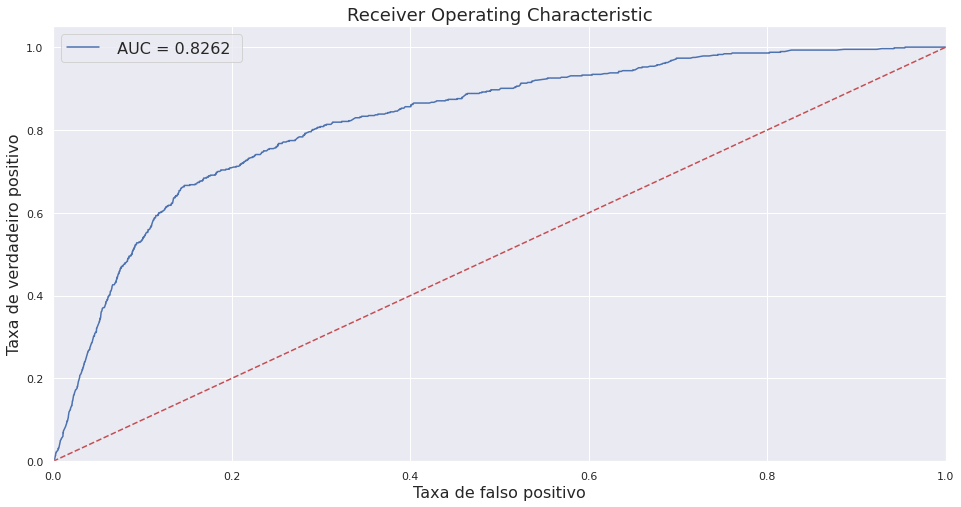

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = roc_curve (yTest, predicted) 
roc_auc = metrics.auc (fpr, tpr)
# Traçando a curva ROC 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots (figsize = (16, 8)) 
plt.title ('Receiver Operating Characteristic', fontsize = 18) 
plt.plot (fpr, tpr, label =' AUC =% 0.4f '% roc_auc) 
plt.legend (loc ='upper left', fontsize = 16) 
plt.plot ([0, 1], [0, 1], 'r--') 
plt.xlim ([0, 1]) 
plt.ylim ([0, 1.05]) 
plt. ylabel ('Taxa de verdadeiro positivo', fontsize = 16) 
plt.xlabel ('Taxa de falso positivo', fontsize = 16) 
plt.show ()

# Vamos fazer **Tuning dos Hiperparâmetros** em nosso modelo XGBClassifier Utilizando Grid Search do scikit-learn

A pesquisa fornecida pelo GridSearchCV gera exaustivamente candidatos a partir de uma grade de valores de parâmetro especificados com o parâmetro param_grid.  A instância GridSearchCV implementa a API usual do estimador: ao “ajustá-la” em um conjunto de dados, todas as combinações possíveis de valores de parâmetros são avaliadas e a** melhor combinação é mantida**.

# GridSearchCV - XGBClassifier




In [ ]:
# Parametros
paramGrid = dict (
    missing          = [np.nan],
    max_depth        = [4, 5, 6], 
    n_estimators     = [340, 350, 360], 
    learning_rate    = [0.03, 0.001], 
    nthread          = [4], 
    subsample        = [0.94, 0.95], 
    colsample_bytree = [0.85], 
    seed             = [100]
)

In [ ]:
# Instanciando o Modelo
xgbcf = XGBClassifier(random_state=42)

# GridSearch
gridSearch = GridSearchCV(xgbcf, param_grid= paramGrid,cv=10, n_jobs=-1)

# Treinando o modelo
gridSearch.fit(X_MinMax[best_method], target)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_...weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.85],
                         'learning_rate': [0.03, 0.001], 'max_depth': [4, 5, 6],
                         'missing': [nan], '

In [ ]:
# Print Melhores parametros para o Modelo
gridSearch.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=340, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
              silent=None, subsample=0.94, verbosity=1)

In [ ]:
'''
Best Estimator:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=340, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
              silent=None, subsample=0.94, verbosity=1)
'''

# Função para Modelo XGBClassifier

In [ ]:
def modelo_xgb(X, y, Xtest, ytest):

  model = XGBClassifier()
  model = model.fit(X, y)

  pred = model.predict(Xtest)

  score = accuracy_score(ytest, pred)
  print("Acuracia do Modelo é de: {:.3f}%". format(score * 100))
  print("\n")
  auc = roc_auc_score(yTest, model.predict_proba(Xtest)[:,1])

  print("Valor auc do Modelo é de: {:.4f}". format(auc))
  print("\n")
  
  print(classification_report(yTest, pred))
  print("\n")
  
  cx = confusion_matrix(yTest, pred)
  labels = ['Satisfeito','Insatisfeito']
  sns.heatmap(cx, annot=True, cmap=plt.cm.Blues, fmt= '.0f', xticklabels= labels, yticklabels=labels)

In [ ]:
# divisão da base de dados de Treino e gerar 20% dessa base para testar nosso modelo.
XTrain, XTest, yTrain, yTest = train_test_split(X_MinMax[df_data.loc['rfe']], target, test_size = 0.2, stratify = target, random_state = 100)

## Avaliando a performance do Modelo usando MinMaxScale e a técnica RFE

Acuracia do Modelo é de: 96.047%


Valor auc do Modelo é de: 0.8262


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13680
           1       0.00      0.00      0.00       563

    accuracy                           0.96     14243
   macro avg       0.48      0.50      0.49     14243
weighted avg       0.92      0.96      0.94     14243





/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



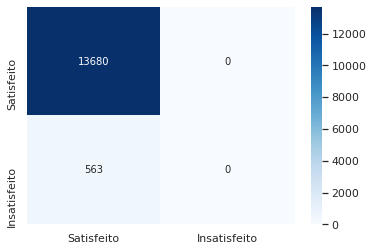

In [ ]:
modelo_xgb(XTrain, yTrain, XTest, yTest )

## Avaliando a performance do Modelo usando StandarScaler e a técnica RFE

In [ ]:
# divisão da base de dados de Treino e gerar 20% dessa base para testar nosso modelo.
XTrain, XTest, yTrain, yTest = train_test_split(X_scaler[df_data.loc['rfe']], target, test_size = 0.2, stratify = target, random_state = 100)

Acuracia do Modelo é de: 96.047%


Valor auc do Modelo é de: 0.8262


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13680
           1       0.00      0.00      0.00       563

    accuracy                           0.96     14243
   macro avg       0.48      0.50      0.49     14243
weighted avg       0.92      0.96      0.94     14243





/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



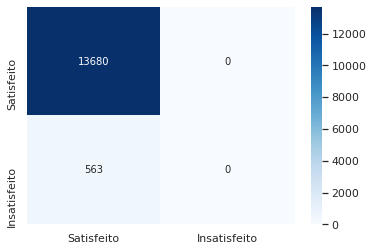

In [ ]:
modelo_xgb(XTrain, yTrain, XTest, yTest )

## Avaliando a performance do Modelo usando PowerTransformer e a técnica RFE

In [ ]:
# divisão da base de dados de Treino e gerar 20% dessa base para testar nosso modelo.
XTrain, XTest, yTrain, yTest = train_test_split(X_TrainPower[df_data.loc['rfe']], target, test_size = 0.2, stratify = target, random_state = 100)

Acuracia do Modelo é de: 96.047%


Valor auc do Modelo é de: 0.8256


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13680
           1       0.00      0.00      0.00       563

    accuracy                           0.96     14243
   macro avg       0.48      0.50      0.49     14243
weighted avg       0.92      0.96      0.94     14243





/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



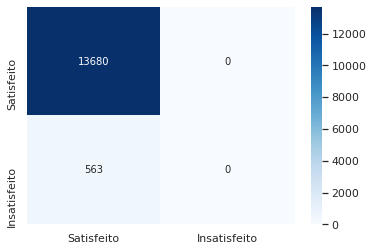

In [ ]:
modelo_xgb(XTrain, yTrain, XTest, yTest )

## Avaliando a performance do Modelo usando PowerTransformer

In [ ]:
# divisão da base de dados de Treino e gerar 20% dessa base para testar nosso modelo.
XTrain, XTest, yTrain, yTest = train_test_split(X_power, target, test_size = 0.2, stratify = target, random_state = 41)

Acuracia do Modelo é de: 96.047%


Valor auc do Modelo é de: 0.8407


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13680
           1       0.50      0.00      0.00       563

    accuracy                           0.96     14243
   macro avg       0.73      0.50      0.49     14243
weighted avg       0.94      0.96      0.94     14243





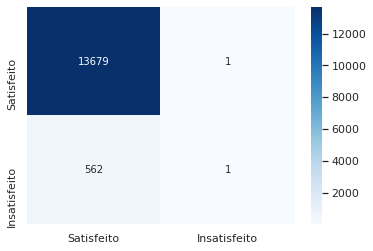

In [ ]:
modelo_xgb(XTrain, yTrain, XTest, yTest)

# Curvas de Calibração

In [ ]:
!pip install scikit-plot

(-0.02, 1.0)

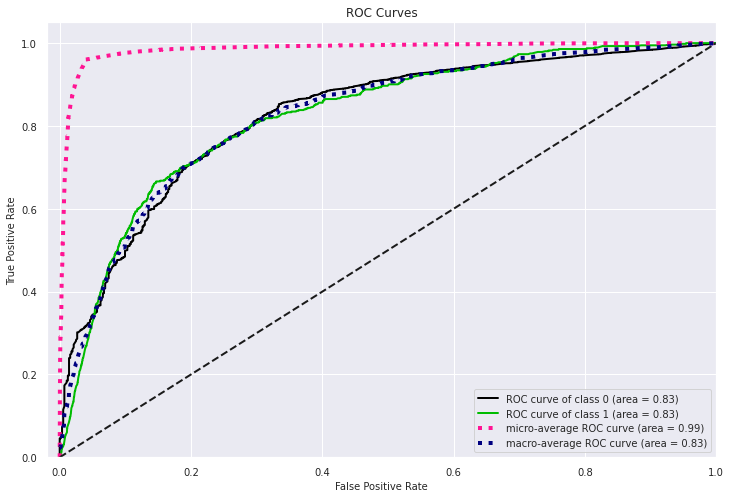

In [ ]:
import scikitplot as skplt
predroc  = xgp.predict_proba(XTest)
skplt.metrics.plot_roc(yTest, predroc, figsize=(12,8))
plt.xlim(-0.02)
plt.show();

Traçar as curvas de calibração de um classificador é útil para determinar se você pode ou não interpretar suas probabilidades previstas diretamente como um nível de confiança. Por exemplo, um classificador binário bem calibrado deve classificar as amostras de forma que, para as amostras para as quais deu uma pontuação de 0,8, cerca de 80% devem realmente ser da classe positiva.

Esta função atualmente funciona apenas para classificação binária.

In [ ]:
import scikitplot as skplt
rf = RandomForestClassifier()
lr = LogisticRegression()                 
xgb = XGBClassifier()
svm = SVC()
rf_probas = rf.fit(XTrain, yTrain).predict_proba(XTest)
lr_probas = lr.fit(XTrain, yTrain).predict_proba(XTest)
xgb_probas = xgb.fit(XTrain, yTrain).predict_proba(XTest)
svm_scores = svm.fit(XTrain, yTrain).decision_function(XTest)


In [ ]:
xgbc = xgbc.fit(XTrainS, yTrainS, eval_metric='auc', early_stopping_rounds=20,eval_set=[(XTest, yTest )])

print("AUC", roc_auc_score(yTest, xgbc.predict_proba(XTest)[:,1]))

In [ ]:
cfx = confusion_matrix(yTest, pred)
cfx

In [ ]:
labels = ['Satisfeito','Insatisfeito']

In [ ]:
plot_confusion_matrix(xg, XTrain, yTrain, cmap=plt.cm.Blues, values_format= '.0f'), plt.title('No Normalize')
#plot_confusion_matrix(xg, X_MinMax, target, normalize='true', values_format= '.2%')
#plot_confusion_matrix(xg, X_MinMax, target, normalize='pred', values_format= '.2%')
#lot_confusion_matrix(xg, X_MinMax, target, cmap=plt.cm.Blues,normalize='all', values_format= '.2%')


In [ ]:
sns.heatmap(cfx, annot=True, cmap=plt.cm.Blues, fmt= '.0f', xticklabels= labels, yticklabels=labels)

In [ ]:
# predict teste

predTeste = xg.predict(X_test)

In [ ]:
predTeste.shape

In [ ]:
# treinanto o modelo com o chi2
modelo_chi2 = modelos(X = X_MinMax[list(df_data.loc['chi2'])],
              y = target)

In [ ]:
np.bincount(target)

# SMOTE

SMOTE (Synthetic Minority Over-sampling Technique).

Consiste em gerar dados sintéticos (não duplicados) da classe minoritária a partir de vizinhos.
SMOTE (Synthetic Minority Over-sampling Technique).

Consiste em gerar dados sintéticos (não duplicados) da classe minoritária a partir de vizinhos. Primeiro seleciona uma instância de classe minoritária a aleatoriamente e encontra seus k vizinhos de classe minoritária mais próximos. A instância sintética é então criada escolhendo um dos k vizinhos mais próximos b aleatoriamente e conectando aeb para formar um segmento de linha no espaço de recurso

Vimos acima que nosso modelo aprendeu mais a classe 0 do que a classe 1. Na verdade não conseguiu prever nenhum valor da classe 1. Embora tivemos uma boa acuracia nosso modelo estava enviesado, pois aprendeu mais de um classe que de outra e isso não é bom para nosso modelo.
Com a Técnica de SMOTE iremos gerar dados Sintéticos da classe minoritária e veremos o comportamento do nosso modelo.

In [ ]:
# Instanciando a classe
smote = SMOTE()

# fit do Smote
X_s, y_s = smote.fit_sample(X_train, target)

In [ ]:
# contagem das classes
np.bincount(y_s)

array([68398, 68398])

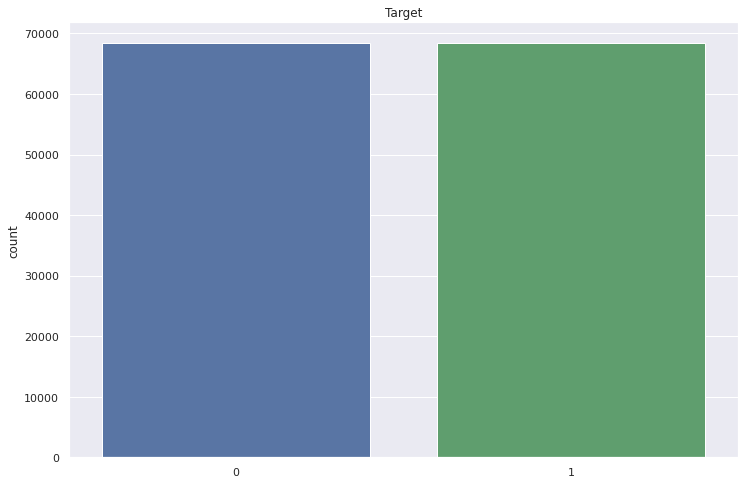

In [ ]:
# Plot dos dados alterados
plt.figure(figsize=(12,8))
sns.countplot(y_s)
plt.title("Target");

In [ ]:
# Criando DataFrame
X_s = pd.DataFrame(X_s, columns=[X_MinMax])
# Print 5 primeira linhas
X_s.head()

In [ ]:
# Divisão da base de dados de Treino e gerar 20% dessa base para testar nosso modelo com SMOTE.
XTrainS, XTestS, yTrainS, yTestS = train_test_split(X_s, y_s, test_size = 0.2, stratify = y_s, random_state = 41)

# Utilizando modelo XGBClassifier com SMOTE

In [ ]:
# Instanciando o Modelo
xg = XGBClassifier()

# Treinando o modelo
xg = xg.fit(XTrainS, yTrainS)

# Predict
pred = xg.predict(XTestS)

# Print Score
accuracy_score(yTestS, pred)

0.9308479532163743

In [ ]:
# Predict Probabalilidade do Modelo
predicted  = xg.predict_proba(XTestS)[:,1]

# Visualizando roc_auc_score
auc_xgb = roc_auc_score(yTestS, predicted)

array([0.92241246, 0.99838793, 0.0497978 , ..., 0.74493235, 0.25617412,
       0.9391054 ], dtype=float32)

In [ ]:
# Print classification_report
print(classification_report(yTestS,pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13680
           1       0.93      0.93      0.93     13680

    accuracy                           0.93     27360
   macro avg       0.93      0.93      0.93     27360
weighted avg       0.93      0.93      0.93     27360



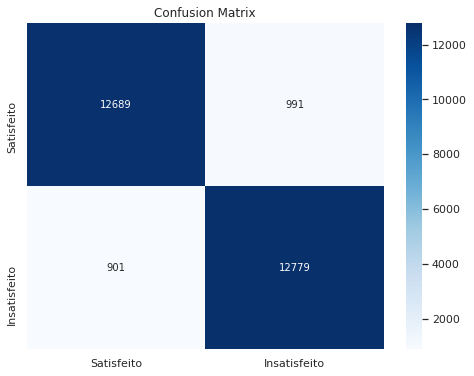

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(8,6))
cmxs = confusion_matrix(yTestS, pred)
labels = ['Satisfeito','Insatisfeito']
sns.heatmap(cmxs, annot=True, cmap=plt.cm.Blues, fmt= '.0f', xticklabels= labels, yticklabels=labels)
plt.title("Confusion Matrix");

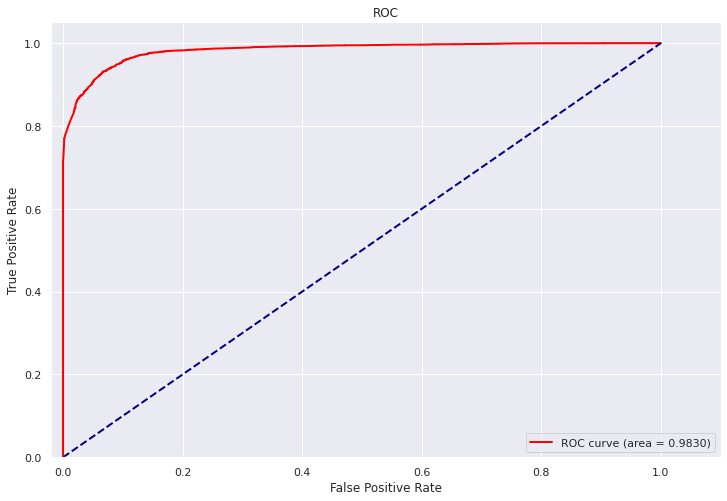

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, _ = roc_curve (yTestS, y_predicted) 
roc_auc = metrics.auc (fpr, tpr)

# Traçando a curva ROC 
plt.figure(figsize=(12,8))
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# Utilizando modelo RandomForest com SMOTE

In [ ]:
# Instanciando um objeto da classe RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=41, criterion='gini')

# Treinando o modelo normalizado com os dados de treino.
rf.fit(XTrainS, yTrainS)

# Fazendo previsão.
predrf = rf.predict(XTestS)

# verificando o score
score = accuracy_score(yTestS, predrf)
print(score)

0.970577485380117


In [ ]:
# Predict Probabalilidade do Modelo
predictrf  = rf.predict_proba(XTestS)[:,1]

# Visualizando roc_auc_score
auc = roc_auc_score(yTestS, predictrf)
auc

0.992560828011183

In [ ]:
# Print classification_report
print(classification_report(yTestS, predrf))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     13680
           1       0.98      0.96      0.97     13680

    accuracy                           0.97     27360
   macro avg       0.97      0.97      0.97     27360
weighted avg       0.97      0.97      0.97     27360



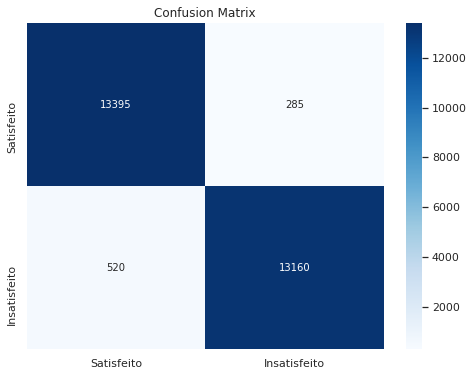

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(8,6))
cmrf = confusion_matrix(yTestS, predrf)
labels = ['Satisfeito','Insatisfeito']
sns.heatmap(cmrf, annot=True, cmap=plt.cm.Blues, fmt= '.0f', xticklabels= labels, yticklabels=labels)
plt.title("Confusion Matrix");

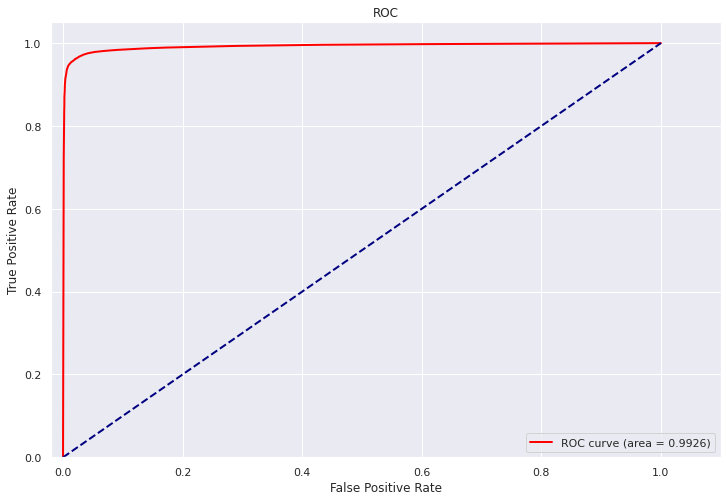

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, _ = roc_curve (yTestS, predictrf) 
roc_auc = metrics.auc (fpr, tpr)

# Traçando a curva ROC 
plt.figure(figsize=(12,8))
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

O modelo RandomForest com Smote melhorou a Recall de média **93** para **97** e aumentou a curva Roc de **98,30** para **99,26**.
Agora nosso modelo aprendeu sobre as duas classes e ainda conseguiu um ótima **acurácia de 97,06%**

Nesse tipo de dados a Acuracia não é o fator principal precisamos nesse casos trabalhar com Precision e Recal para avaliar o comportamento do nosso Modelo.

# Previsão com dados de teste

In [ ]:
pred_model_Final = rf.predict_proba(X_Test)[:,1]

## Salvando a Previsão do Modelo para enviar a Submissão

In [ ]:
# salvando as previsões
pd.DataFrame({
    'ID' : test_id,
    'TARGET' : pred_model_Final
}).to_csv('/content/drive/MyDrive/Colab Notebooks/Santander/sub.csv', index = False)

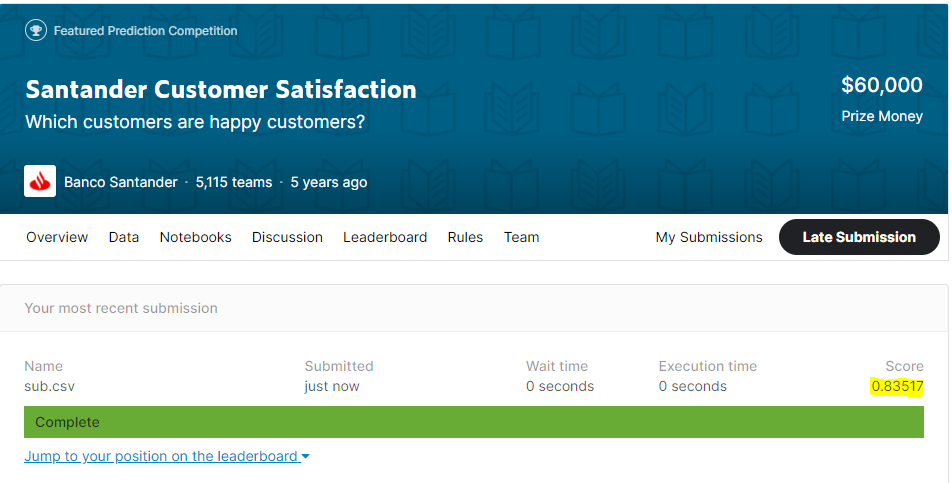

Finalizamos a análise, vimos que o algoritmo **RandomForest**, gerou o modelo com o melhor score para a acurácia e métrica ROC AUC. O Score para os dados de teste ROC AUC pela avaliação do Kaggle foi: **0.83517**.

## **Contato**

**Dúvidas e sugestões entre em contato!**

<table align='center'>
    <tr style=" background-color: #f2f2f2;">
        <td>
            <img src="https://api.iconify.design/clarity:email-outline-badged.svg" alt="Email" height="42" width="42">
        </td>
        <td>
            <p>
                <a href="mailto:eduardojhoanes@gmail.com">E-mail</href>
            </p>
        </td>
    <td>
            <img src="https://api.iconify.design/ant-design:linkedin-outlined.svg" alt="Linkedin" height="42" width="42">
    </td>
    <td>
        <p>
            <a href="https://www.linkedin.com/in/carlos-eduardo-silva-bh/">Linkedin</href>
        </p>
    </td>
    <td>
        <img src="https://api.iconify.design/bx:bxl-github.svg" alt="Github" height="42" width="42">
    </td>
    <td>
        <p>
            <a href="https://github.com/CarlosEduardoBH">Github</href>
        </p>
    </td>
    <td>
        <img src="https://api.iconify.design/clarity:world-outline-badged.svg" alt="Site" height="42" width="42">
    </td>
    <td>
        <p>
            <a href="https://github.com/carloseduardobh/">Site</href>
        </p>
    </td>
  </tr>
</table>




<script src="https://code.iconify.design/1/1.0.7/iconify.min.js"></script>